# Raw subject

### 1.1. Import & cấu hình file

In [19]:
import os

# Phần 1: Import thư viện & cấu hình đường dẫn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

# Đổi lại dict này theo tên mô hình & file của bạn
model_to_file = {
    "resnet34": "resnet34.csv",
    "resnet34_bmi_sex": "resnet34_bmi_sex.csv",
    "resnet34_coralLoss": "resnet34_coralLoss.csv",
    # thêm mô hình khác vào đây...
}

dir_data = "oof_predictions"


### 1.2 – Đọc & gộp tất cả kết quả

In [20]:
# Phần 2: Đọc tất cả CSV và gộp lại thành một DataFrame

dfs = []
for model_name, file_path in model_to_file.items():
    df = pd.read_csv(os.path.join(dir_data, file_path), dtype={"ID": str})

    # Đảm bảo có các cột cần thiết
    required_cols = {"ID", "y_true", "y_pred"}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"File {file_path} thiếu một trong các cột {required_cols}")

    df["model"] = model_name
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
print(df_all.head())
print("Tổng số dòng:", len(df_all))


   fold  row_index    ID  y_true  y_pred     model
0     5          0  0001       0       0  resnet34
1     5          1  0001       0       0  resnet34
2     3          2  0004       1       1  resnet34
3     3          3  0004       1       1  resnet34
4     3          4  0004       1       1  resnet34
Tổng số dòng: 10086


In [21]:
import pandas as pd
subject_df = pd.read_csv('../data/subject-info_raw.csv', dtype = {"ID": str})

# Kiểm tra
print(subject_df.head())
print("Số ID trong subject.csv:", subject_df["ID"].nunique())

     ID  Age_group  Sex   BMI  Length  Device
0  0001        2.0  1.0  23.0      15       0
1  0002        2.0  1.0  24.0      32       0
2  0003        7.0  1.0  28.0      30       0
3  0004        4.0  0.0  24.0      15       0
4  0005        2.0  1.0  20.0      15       0
Số ID trong subject.csv: 1121


In [22]:
# Phần 1: Merge subject metadata vào df_all
df_merged = df_all.merge(subject_df, on="ID", how="left")

print("Số dòng sau merge:", len(df_merged))
print("Missing group_age:", df_merged["Age_group"].isna().sum())
df_merged

Số dòng sau merge: 10086
Missing group_age: 0


,fold,row_index,ID,y_true,y_pred,model,Age_group,Sex,BMI,Length,Device
0,5,0,0001,0,0,resnet34,2.0,1.0,23.0,15,0
1,5,1,0001,0,0,resnet34,2.0,1.0,23.0,15,0
2,3,2,0004,1,1,resnet34,4.0,0.0,24.0,15,0
3,3,3,0004,1,1,resnet34,4.0,0.0,24.0,15,0
4,3,4,0004,1,1,resnet34,4.0,0.0,24.0,15,0
...,...,...,...,...,...,...,...,...,...,...,...
10081,2,3357,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10082,2,3358,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10083,2,3359,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10084,2,3360,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0


### 1.3 – Tính độ chính xác theo ID cho từng mô hình

In [23]:
# Phần 3: Tính ID-level accuracy cho từng mô hình

def compute_id_stats(df):
    """Tính số sample, số đúng, accuracy theo ID & model."""
    grp = df.groupby(["model", "ID"])
    stats = grp.apply(
        lambda g: pd.Series({
            "n_samples": len(g),
            "n_correct": (g["y_true"] == g["y_pred"]).sum(),
            "id_acc": (g["y_true"] == g["y_pred"]).mean()
        }),
        include_groups=False
    ).reset_index()
    return stats

id_stats = compute_id_stats(df_all)

# Gán nhãn "good / bad / medium"
id_stats["perf_label"] = pd.cut(
    id_stats["id_acc"],
    bins=[-0.01, 0.0, 0.5, 0.9, 1.0],
    labels=["always_wrong", "mostly_wrong", "medium", "perfect"],
    include_lowest=True
)

# print(id_stats.head())
id_stats

,model,ID,n_samples,n_correct,id_acc,perf_label
0,resnet34,0001,2.0,2.0,1.0,perfect
1,resnet34,0002,6.0,6.0,1.0,perfect
2,resnet34,0003,5.0,5.0,1.0,perfect
3,resnet34,0004,3.0,3.0,1.0,perfect
4,resnet34,0005,3.0,3.0,1.0,perfect
...,...,...,...,...,...,...
3274,resnet34_coralLoss,1117,4.0,4.0,1.0,perfect
3275,resnet34_coralLoss,1118,2.0,0.0,0.0,always_wrong
3276,resnet34_coralLoss,1119,6.0,6.0,1.0,perfect
3277,resnet34_coralLoss,1120,3.0,3.0,1.0,perfect


### 1.4 – So sánh giữa các mô hình: ID nào luôn đúng / luôn sai

In [24]:
# Phần 4: So sánh giữa các mô hình trên từng ID

# Tính min/max accuracy theo ID qua tất cả mô hình
id_agg = (
    id_stats.groupby("ID")["id_acc"]
    .agg(["min", "max", "mean"])
    .reset_index()
    .rename(columns={"mean": "mean_acc"})
)

# ID luôn đúng ở TẤT CẢ mô hình (id_acc == 1.0 ở mọi model)
ids_always_correct = id_agg[id_agg["min"] == 1.0]["ID"].tolist()

# ID luôn sai ở TẤT CẢ mô hình (id_acc == 0.0 ở mọi model)
ids_always_wrong = id_agg[id_agg["max"] == 0.0]["ID"].tolist()

print("✅ IDs luôn đúng trên tất cả mô hình:", ids_always_correct[:50])
print("❌ IDs luôn sai trên tất cả mô hình:", ids_always_wrong[:50])
print(f"Số ID luôn đúng: {len(ids_always_correct)}, luôn sai: {len(ids_always_wrong)}")


✅ IDs luôn đúng trên tất cả mô hình: ['0001', '0011', '0017', '0018', '0019', '0020', '0025', '0031', '0033', '0038', '0040', '0041', '0042', '0049', '0056', '0058', '0059', '0060', '0062', '0063', '0064', '0066', '0069', '0072', '0079', '0081', '0095', '0097', '0098', '0099', '0105', '0107', '0108', '0109', '0110', '0113', '0116', '0118', '0119', '0125', '0128', '0135', '0137', '0150', '0155', '0160', '0166', '0170', '0173', '0177']
❌ IDs luôn sai trên tất cả mô hình: ['0021', '0027', '0052', '0068', '0070', '0073', '0085', '0088', '0093', '0112', '0114', '0120', '0126', '0130', '0131', '0132', '0134', '0139', '0140', '0144', '0147', '0157', '0163', '0165', '0171', '0192', '0194', '0195', '0204', '0212', '0226', '0230', '0242', '0248', '0251', '0275', '0278', '0288', '0314', '0321', '0332', '0333', '0340', '0353', '0355', '0356', '0365', '0373', '0382', '0390']
Số ID luôn đúng: 328, luôn sai: 158


In [25]:
df_merged

,fold,row_index,ID,y_true,y_pred,model,Age_group,Sex,BMI,Length,Device
0,5,0,0001,0,0,resnet34,2.0,1.0,23.0,15,0
1,5,1,0001,0,0,resnet34,2.0,1.0,23.0,15,0
2,3,2,0004,1,1,resnet34,4.0,0.0,24.0,15,0
3,3,3,0004,1,1,resnet34,4.0,0.0,24.0,15,0
4,3,4,0004,1,1,resnet34,4.0,0.0,24.0,15,0
...,...,...,...,...,...,...,...,...,...,...,...
10081,2,3357,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10082,2,3358,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10083,2,3359,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0
10084,2,3360,1119,0,0,resnet34_coralLoss,2.0,0.0,26.0,33,0


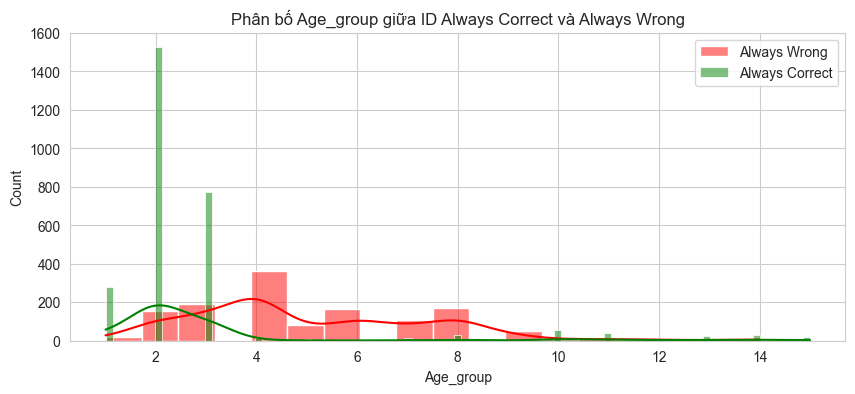

In [26]:
df_wrong = df_merged[df_merged["ID"].isin(ids_always_wrong)]
df_correct = df_merged[df_merged["ID"].isin(ids_always_correct)]

plt.figure(figsize=(10,4))
sns.histplot(df_wrong["Age_group"], color="red", kde=True, label="Always Wrong")
sns.histplot(df_correct["Age_group"], color="green", kde=True, label="Always Correct")

plt.legend()
plt.title("Phân bố Age_group giữa ID Always Correct và Always Wrong")
plt.show()


In [27]:
plt.figure(figsize=(10,5))
sns.countplot(
    data=df_merged.drop_duplicates("ID"),
    x="Age_group",
    hue="id_status",
    palette="Set2"
)
plt.title("Phân bổ y_true giữa các nhóm ID")
plt.show()


ValueError: Could not interpret value `id_status` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

### 1.5 – Trực quan hóa: phân phối ID accuracy cho từng mô hình

In [ ]:
# Phần 5: Histogram phân phối độ chính xác theo ID cho từng mô hình

for model_name, sub in id_stats.groupby("model"):
    plt.figure()
    plt.hist(sub["id_acc"], bins=11, range=(0, 1))
    plt.title(f"ID-level accuracy distribution – {model_name}")
    plt.xlabel("ID accuracy")
    plt.ylabel("Number of IDs")
    plt.tight_layout()
    plt.show()


## 🔥 Phần 6 – Heatmap: so sánh các mô hình trên các ID "khó" nhất

In [ ]:
# Phần 6: Heatmap cho các ID khó nhất

# Chọn K ID khó nhất (mean_acc thấp nhất)
K = 30  # đổi tùy bạn
hard_ids = id_agg.sort_values("mean_acc", ascending=True).head(K)["ID"].tolist()

subset = id_stats[id_stats["ID"].isin(hard_ids)]

# Pivot: rows = ID, columns = model, values = id_acc
heat_data = subset.pivot(index="ID", columns="model", values="id_acc")

print("Kích thước heatmap:", heat_data.shape)
display(heat_data.head())

plt.figure(figsize=(10, max(6, 0.3 * len(heat_data))))
plt.imshow(heat_data.values, aspect="auto")
plt.xticks(range(len(heat_data.columns)), heat_data.columns, rotation=45, ha="right")
plt.yticks(range(len(heat_data.index)), heat_data.index)
plt.colorbar(label="ID accuracy")
plt.title("Per-ID accuracy by model – hardest IDs")
plt.tight_layout()
plt.show()


## 💾 Phần 7 – Lưu summary để phân tích thêm (Excel / CSV)

In [ ]:
# Phần 7: Lưu kết quả để xem trong Excel

id_stats.to_csv("id_model_accuracy_detail.csv", index=False)
id_agg.to_csv("id_overall_difficulty_summary.csv", index=False)

print("Đã lưu:")
print("- id_model_accuracy_detail.csv (model, ID, n_samples, n_correct, id_acc)")
print("- id_overall_difficulty_summary.csv (ID, min, max, mean_acc)")


### Phần 0: Load subject metadata (ID, BMI, SEX, group_age)


In [ ]:
import pandas as pd
subject_df = pd.read_csv('../data/subject-info_raw.csv', dtype = {"ID": str})

# Kiểm tra
print(subject_df.head())
print("Số ID trong subject.csv:", subject_df["ID"].nunique())

### 📌 PHẦN 1 – Merge metadata vào dữ liệu prediction

In [ ]:
# Phần 1: Merge subject metadata vào df_all
df_merged = df_all.merge(subject_df, on="ID", how="left")

print("Số dòng sau merge:", len(df_merged))
print("Missing group_age:", df_merged["Age_group"].isna().sum())
df_merged

### 📌 PHẦN 2 – Tính accuracy theo group_age cho từng mô hình

In [ ]:
# Phần 2: Accuracy per group_age per model

age_stats = (
    df_merged
    .assign(correct=lambda x: (x["y_true"] == x["y_pred"]).astype(int))
    .groupby(["model", "Age_group"])
    .agg(
        n_samples=("correct", "count"),
        n_correct=("correct", "sum"),
        age_acc=("correct", "mean")
    )
    .reset_index()
)

print(age_stats)


### 📌 PHẦN 3 – Tìm group_age khó nhất

In [ ]:
# Phần 3: Tìm group_age khó nhất theo trung bình accuracy của tất cả model

group_diff = (
    age_stats.groupby("Age_group")["age_acc"]
    .agg(["mean", "min", "max"])
    .rename(columns={"mean": "mean_acc"})
    .sort_values("mean_acc")
)

print("=== Mức độ khó theo Age_group (trung bình tất cả mô hình) ===")
display(group_diff)


### 📌 PHẦN 4 – Trực quan 1: Bar chart accuracy per age group theo từng mô hình

In [ ]:
# Phần 4: Bar chart accuracy theo group_age cho từng model

import seaborn as sns
plt.figure(figsize=(10, 5))

sns.barplot(
    data=age_stats,
    x="Age_group",
    y="age_acc",
    hue="model"
)

plt.title("Model Accuracy by Age Group")
plt.ylabel("Accuracy")
plt.xlabel("Group Age")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()


### 📌 PHẦN 5 – Trực quan 2: Heatmap so sánh các mô hình theo group_age

In [ ]:
# Phần 5: Heatmap accuracy per model × group_age

heat_age = age_stats.pivot(index="Age_group", columns="model", values="age_acc")

plt.figure(figsize=(8, 6))
sns.heatmap(heat_age, annot=True, fmt=".2f", cmap="viridis")
plt.title("Accuracy Heatmap — Model vs Age Group")
plt.xlabel("Model")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


### 📌 PHẦN 6 – Xếp hạng độ khó của từng group_age

In [ ]:
# Phần 6: Ranking độ khó theo group_age

group_diff["difficulty_rank"] = group_diff["mean_acc"].rank(ascending=True)
display(group_diff)


### 📌 PHẦN 7 – Nếu bạn muốn xem chi tiết ID nào trong group_age gây lỗi

In [ ]:
hardest = group_diff.index[0]  # group_age đầu tiên trong ranking (khó nhất)

print(f"Group age khó nhất: {hardest}")

subset = df_merged[df_merged["Age_group"] == hardest]

# Tính accuracy per ID trong age group đó
id_in_age = (
    subset.assign(correct=lambda x: (x["y_true"] == x["y_pred"]))
    .groupby(["model", "ID"])
    .agg(age_id_acc=("correct", "mean"))
    .reset_index()
)

display(id_in_age.sort_values("age_id_acc").head(20))


In [ ]:
def map_agegroup_to_class(age_group: int) -> int:
    """
    Map Age_group (1..15) -> age bucket class (1..4)
    1 -> [1,2,3]
    2 -> [4,5]
    3 -> [6,7]
    4 -> [8..15]
    """
    if age_group in [1, 2, 3]:
        return 1
    elif age_group in [4, 5]:
        return 2
    elif age_group in [6, 7]:
        return 3
    elif 8 <= age_group <= 15:
        return 4
    else:
        return None  # hoặc np.nan nếu bạn muốn


In [ ]:
# True fine-grained age group (1..15) từ subject.csv
df_merged["age_group_true"] = df_merged["Age_group"]

# True bucket class (1..4) suy từ Age_group
df_merged["age_bucket_true"] = df_merged["age_group_true"].apply(map_agegroup_to_class)


In [ ]:
# Model output 0..3 -> map sang class 1..4
df_merged["age_bucket_pred"] = df_merged["y_pred"] + 1


In [ ]:
# Đánh dấu đúng / sai
df_merged["correct"] = (df_merged["age_bucket_true"] == df_merged["age_bucket_pred"])

# Lọc các mẫu bị sai
df_wrong_bucket = df_merged[~df_merged["correct"]]

# Đếm: true bucket -> predicted bucket
bucket_confusion = (
    df_wrong_bucket
    .groupby(["age_bucket_true", "age_bucket_pred"])
    .size()
    .reset_index(name="count")
    .sort_values(["age_bucket_true", "count"], ascending=[True, False])
)

bucket_confusion


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_bucket = (
    df_merged
    .groupby(["age_bucket_true", "age_bucket_pred"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(6,5))
sns.heatmap(cm_bucket, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Age Buckets (1–4)")
plt.xlabel("Predicted bucket")
plt.ylabel("True bucket")
plt.tight_layout()
plt.show()


In [ ]:
cm_bucket_wrong = (
    df_wrong_bucket
    .groupby(["age_bucket_true", "age_bucket_pred"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(6,5))
sns.heatmap(cm_bucket_wrong, annot=True, fmt="d", cmap="Reds")
plt.title("Misclassifications between Age Buckets (1–4)")
plt.xlabel("Predicted bucket")
plt.ylabel("True bucket")
plt.tight_layout()
plt.show()


In [ ]:
for b in sorted(df_merged["age_bucket_true"].dropna().unique()):
    sub = bucket_confusion[bucket_confusion["age_bucket_true"] == b]
    print(f"\n=== Bucket {b} bị nhầm sang ===")
    print(sub)


In [ ]:
df_wrong = df_merged[df_merged["age_bucket_true"] != df_merged["age_bucket_pred"]]


In [ ]:
wrong_by_agegroup = (
    df_wrong.groupby(["age_bucket_true", "Age_group"])
    .size()
    .reset_index(name="count")
    .sort_values(["age_bucket_true", "count"], ascending=[True, False])
)

wrong_by_agegroup


In [ ]:
for b in sorted(wrong_by_agegroup["age_bucket_true"].unique()):
    sub = wrong_by_agegroup[wrong_by_agegroup["age_bucket_true"] == b]
    print(f"\n=== Bucket {b} bị sai nhiều nhất ở Age_group ===")
    print(sub.head(10))


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

heat_wrong = (
    df_wrong.groupby(["age_bucket_true", "Age_group"])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(12, 5))
sns.heatmap(heat_wrong, annot=False, cmap="Blues")
plt.title("Misclassification Distribution: Bucket True × Fine Age_group")
plt.xlabel("Fine Age_group (1–15)")
plt.ylabel("Age Bucket True (1–4)")
plt.tight_layout()
plt.show()


In [ ]:
overall_agegroup_error = (
    df_wrong.groupby("Age_group")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

overall_agegroup_error


In [ ]:
wrong_true_vs_pred_fine = (
    df_wrong.groupby(["age_bucket_pred", "Age_group"])
    .size()
    .reset_index(name="count")
    .sort_values(["age_bucket_pred", "count"], ascending=[True, False])
)

wrong_true_vs_pred_fine
